In [62]:
%matplotlib inline
import pandas as pd
import numpy as np

In [38]:
!cd ../2015-khmer-wok2-vc && make -Bn galGal4.align.out

wget -SNc ftp://hgdownload.cse.ucsc.edu/goldenPath/galGal4/bigZips/galGal4.fa.gz
normalize-by-median.py -C 1 -k 21 -x 7e9 -N 4 -R galGal4.fa.gz.keep.gz.info galGal4.fa.gz
gzip galGal4.fa.gz.keep
load-into-counting.py -k 21 -x 7e9 galGal4.dn.k21.kh galGal4.fa.gz.keep.gz
../2015-experimental-graphalign/find-variant-by-align-long.py galGal4.dn.k21.kh /home/chick/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-1_LongRead.fastq.gz --variants-out variants-galGal4.txt > galGal4.align.out


In [55]:
!ls -sh ../2015-khmer-wok2-vc/galGal4.fa.gz
!ls -sh ../2015-khmer-wok2-vc/galGal4.fa.gz.keep.gz
!cat ../2015-khmer-wok2-vc/galGal4.fa.gz.keep.gz.info
print "DONE with galGal4.fa.gz; kept 2381 of 15932 or 14%"
print "fp rate estimated to be 0.000"
print "=" * 60
!ls -sh ../2015-khmer-wok2-vc/galGal4.dn.k21.kh
!cat ../2015-khmer-wok2-vc/galGal4.dn.k21.kh.info

330M ../2015-khmer-wok2-vc/galGal4.fa.gz
298M ../2015-khmer-wok2-vc/galGal4.fa.gz.keep.gz
DONE with galGal4.fa.gz; kept 2381 of 15932 or 14%
fp rate estimated to be 0.000
27G ../2015-khmer-wok2-vc/galGal4.dn.k21.kh
through galGal4.fa.gz.keep.gz
fp rate estimated to be 0.000



In [64]:
reads = {}

with open('../2015-khmer-wok2-vc/galGal4.align.out', 'r') as f:
    for line in f:
        if '%' in line:
            name, start, end, span, percent = line.strip().split()
            reads[name] = {'start': start, 'end':end, 'span':span, 'percent': float(percent[:-1])}

data = pd.DataFrame.from_dict(reads).T

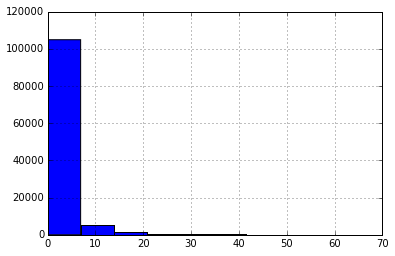

In [65]:
data['percent'].hist()

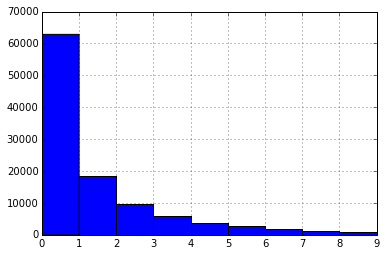

In [66]:
data['percent'].hist(bins=range(0, 10))

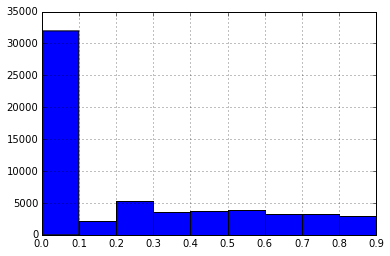

In [67]:
data['percent'].hist(bins=np.arange(0, 1, .1))

## Training

 - K=21
 - Reference: galGal4
 - Query: galGal4.LR6000017-DNA_A01-LRAAA-AllReads.sorted.bam (previously mapped with bwa-mem)

### Problems

 - galGal4 has 'N' and soft-clipped regions. Training script not ready for this in CIGAR:
   ```python
   >>> cigar_to_state
   {0: 'M', 1: 'Ir', 2: 'Ig'}
   >>> rec.cigarstring
   '251S638M1I16M'
   ```
   Does it make sense to support other fields, or should I clean up the reference first? (From http://davetang.org/wiki/tiki-index.php?page=SAM )

| op | Description                                                    |
|----|----------------------------------------------------------------|
| M	 | Alignment match (can be a sequence match or mismatch           |
| I	 | Insertion to the reference                                     |
| D	 | Deletion from the reference                                    |
| N	 | Skipped region from the reference                              |
| S	 | Soft clip on the read (clipped sequence present in <seq>)      |
| H	 | Hard clip on the read (clipped sequence NOT present in <seq>)  |
| P	 | Padding (silent deletion from the padded reference sequence)   |

